# Detección de matrículas con un alto grado de ruido
## Tratamiento del ruido mediante cierres y aperturas con reconstrucción

## Integrantes del grupo

Esta práctica ha sido elaborada por el grupo 19 equipo 2, formado por los estudiantes:
* Sergio Álvarez López
* Mario Hernández García
* José Del Castillo Izquierdo
* Nicolás Forero Arévalo
* Álvaro Martín Jiménez

## I. Introducción

El objetivo de este trabajo será demostrar el tratamiento de imágenes de matrículas con un alto nivel de ruido para la posterior detección de estas.

Este trabajo cuenta con dos partes principales: 
* el tratamiento morfológico para la eliminiación de ruido, donde explicaremos las técnicas morfológicas estudiadas (cierre y apertura con reconstrucción)
* la detección de la matrícula en la imagen una vez se han aplicados las operaciones morfológicas, donde se detallará cómo se ha detectado la matrícula en la imagen ya tratada

## II. Creación del dataset

El primer paso será generar un conjunto de imágenes de matrículas que cuenten con un alto grado de ruido. Para ello tomaremos tres imágenes y las umbralizaremos usando un umbral elevado, produciendo así una considerable cantidad de ruido negro.

Nuestra principal intención en la generación de este conjunto de imágenes ha sido magnificar el ruido para así poder demostrar la efectividad del tratamiento vía aplicaciones morfológicas.

Primeramente definimos todos los imports necesarios para este trabajo.

In [1]:
%matplotlib inline

import numpy as np
import cv2
from cv2 import erode, dilate, getStructuringElement

import os

import matplotlib.pyplot as plt
import matplotlib.image as img

from skimage import io
import skimage
from skimage import data
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

Ahora definimos la función que nos permitirá mostrar las imágenes.

In [2]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(12, 12))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()
    

Finalmente, en la celda siguiente se le pide al usuario que seleccione una de las tres imágenes del dataset según la marca del coche: suzuki, seat o bmw. 

Introduzca el nombre de la imagen que desee ver (suzuki, seat o bmw).
Nombre de la imagen(sin extensión): suzuki


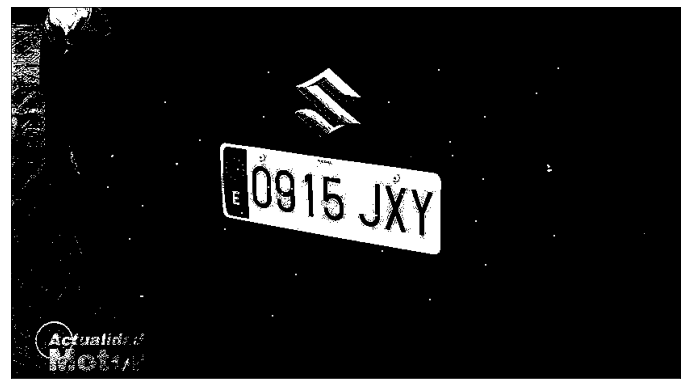

In [3]:
#Para que funcione se deben tener las imágenes descargadas de  github en el almacenamiento interno

print("Introduzca el nombre de la imagen que desee ver (suzuki, seat o bmw).")


list_images = os.listdir("test")
data_files = {}

for filename in list_images:
    data_files[filename.split(".")[0]] = filename.split(".")[1]


while 1:
    image_name = input("Nombre de la imagen(sin extensión): ")

    data_dir = 'test/'

    if image_name in data_files.keys():
        image = os.path.join(data_dir,  image_name + '.' + data_files[image_name])
        img_grises = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        _, img_umbralizada = cv2.threshold(img_grises, 200, 255, cv2.THRESH_BINARY)
        
        break
    else:
        print("\nNo se encuentra la imagen introducida por la entrada. Vuelva a introducir el nombre de la imagen\n")
        continue
         
imshow(img_umbralizada) 

## III. Cierre y Apertura con reconstrucción

Una vez hemos obtenido nuestro dataset de imágenes umbralizadas con un alto nivel de ruido, procedemos a tratarlas mediante operaciones morfológicas con el objetivo de eliminar dicho ruido y habilitar la posterior detección de la matrícula.

Para esto implementaremos tanto el cierre con reconstrucción como la apertura con reconstrución.

Como se ha comentado, las dos operaciones morfológicas que implementaremos serán el cierre con reconstrucción y la apertura con reconstrucción.

Si bien la apertura con reconstrucción ha sido explicado en clase, la implementación del cierre con reconstrucción es original y ha sido inspirada en la idea expuesta en las sesiones. A nivel de notación "+" representa una dilatación y "-" una erosión.

El algoritmo de **apertura con reconstrucción**:
* A_0 = A
* A_1 = (A_0 - SE)
* do
    *    A_n+1 = (A_n + SE) and A_0
* until A_n+1 = A_n

se basa en la idea de primero hacer una erosión, para poder eliminar ruido blanco, y después hacer un bucle iterativo en el que recuperar la mayor cantidad de color blanco posible siempre sin rebasar las zonas blancas originales (es por ello que se usa la operación lógica AND, para que si originalmente el píxel estaba a 0, este nunca se llegue a encender y poner a 1).

Inspirados en esta idea hemos implementado el siguiente algoritmo de **cierre con reconstrucción**:
* A_0 = A
* A_1 = (A_0 + SE)
* do
    *    A_n+1 = (A_n - SE) or A_0
* until A_n+1 = A_n

donde primeramente realizamos una dilatación, para eliminar ruido negro, y luego en el bucle iterativo se van recuperando las zonas negras a base de erosiones. El matiz, radica en que ahora el operador lógico implementado es OR, ya que lo que se busca es que nunca se apague (se ponga a 0) un píxel que antes era blanco (es decir, controlar que la cantidad de negro recuperado mediante las erosiones no sobrepase la inicial). Esto el operador OR lo cumple, ya que si un píxel antes era blanco (i.e. valor 1), nunca después se podrá apagar (i.e. valor 0).


Ambos algoritmos se basarán en el concepto del elemento estructural. Con fines ilustrativos definimos aquí un elemento estructural genérico aunque después buscaremos su tamaño óptimo mediante un bucle iterativo.

In [4]:
# Definimos el elmento estructural
# 
se = getStructuringElement(shape = cv2.MORPH_CROSS, # forma de cruz
                               ksize = (5,5), # tamaño total
                               anchor = (-1,-1) # que el punto de anclaje esté centrado
                                )

A continuación implementamos el cierre con reconstrucción. Obsérvese el uso de la función np.bitwise_or, la cual se encarga de ir aplicando el operador OR píxel a píxel entre las dos matrices.

In [5]:
# Cierre con reconstrucción
# es capaz de quitarte ruido negro y luego asegurarse de que todo lo negro importante se recupere

def cierre_recon(img, se):
    A_0 = img
    A_prev = img
    A = dilate(A_0, se, iterations = 1)
    while not((A == A_prev).all()):
        A_prev = A
        A = np.bitwise_or(erode(A, se, iterations = 1), A_0)
    return A

A continuación implementamos el cierre con reconstrucción. Obsérvese el uso de la función np.bitwise_and, la cual se encarga de ir aplicando el operador AND píxel a píxel entre las dos matrices.

In [6]:
# Apertura con reconstrucción
# es capaz de quitarte ruido blanco y luego asegurarse de que todo lo blanco importante se recupere

def apertura_recon(img, se):
    A_0 = img
    A_prev = img
    A = erode(A_0, se, iterations = 1)
    while not((A == A_prev).all()):
        A_prev = A
        A = np.bitwise_and(dilate(A, se, iterations = 1), A_0)
    return A



Debido a las características de nuestro dataset, las imágenes cuentan con un exceso de ruido negro, por lo que hemos considerado usar primero el algoritmo del cierre con apertura.

Debido a la notable cantidad de ruido de las imágenes, lo hemos compuesto consigo mismo con el objetivo de aprovechar dos veces la erosión con la que se inicia el algoritmo. Nótese que al usar la variante con reconstrucción las operaciones dejan de ser idempotentes. De esta manera hemos conseguido eliminar más ruido negro sin perder las características principales de la matrícula, i.e. que los dígitos y letras mantuvieran su forma original, gracias a las reconstrucciones que han precedido a ambas erosiones permitiendo que dichos dígitos y números no pierdan su forma principal.

Doble cierre aplicado con SE de tamaño 3


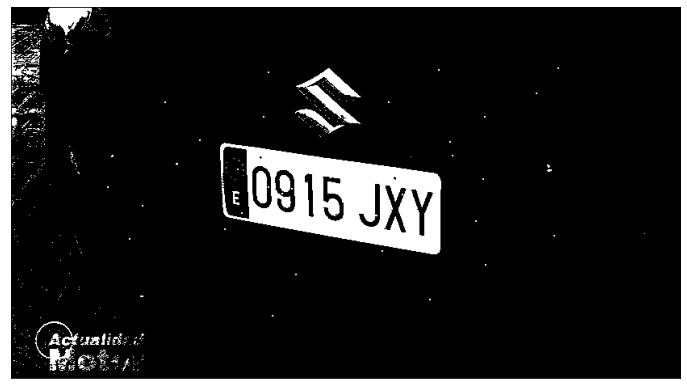

Doble cierre aplicado con SE de tamaño 5


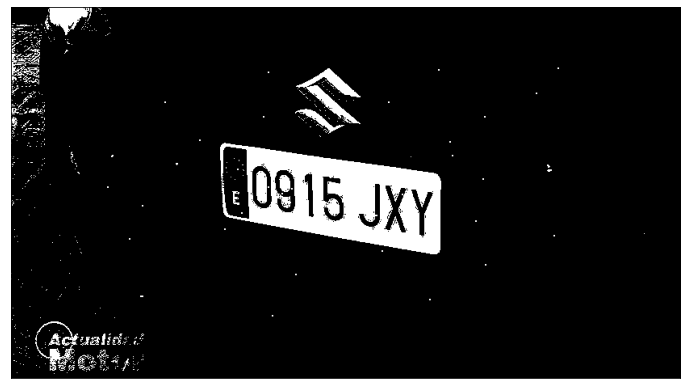

Doble cierre aplicado con SE de tamaño 7


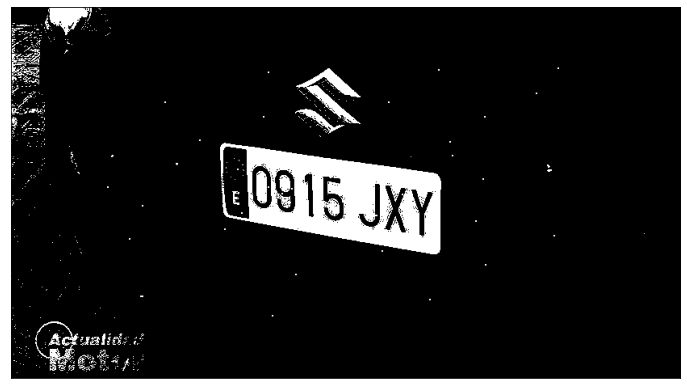

In [7]:
# Bucle para encontrar el tamaño óptimo del SE

for k in range(3, 8, 2):
    se = getStructuringElement(shape = cv2.MORPH_CROSS, # forma de cruz
                               ksize = (k,k), # tamaño total
                               anchor = (-1,-1) # que el punto de anclaje esté centrado
                                )
    
    img_cierre= cierre_recon(img_umbralizada, se)
    doble_cierre = cierre_recon(img_cierre, se)
    print('Doble cierre aplicado con SE de tamaño', k)
    imshow(doble_cierre)


En función a las pruebas que hemos estado desarrollando, hemos determinado que el tamaño óptimo del elemento estructural es (5,5) para las imágenes seat y bmw, mientras que el tamaño óptimo para la imagen de suzuki ha sido (3,3). Esta diferencia en el tamaño estructural se puede explicar debido al menor tamaño de la imagen suzuki.

In [8]:
if image_name == 'suzuki':
    se = getStructuringElement(shape = cv2.MORPH_CROSS, # forma de cruz
                               ksize = (3,3), # tamaño total
                               anchor = (-1,-1) # que el punto de anclaje esté centrado
                                )
    
    img_cierre= cierre_recon(img_umbralizada, se)
    doble_cierre = cierre_recon(img_cierre, se)
    
elif image_name in ('seat','bmw'):
    se = getStructuringElement(shape = cv2.MORPH_CROSS, # forma de cruz
                               ksize = (5,5), # tamaño total
                               anchor = (-1,-1) # que el punto de anclaje esté centrado
                                )
    
    img_cierre= cierre_recon(img_umbralizada, se)
    doble_cierre = cierre_recon(img_cierre, se)
    
    
img_tratada_cierre = doble_cierre
    

Para terminar con los tratamientos morfológicos, eliminamos el ruido blanco que había en la imagen original mediante una apertura con reconstrucción.

Aquí podemos comparar la imagen original con la imagen tratada.

Imagen original


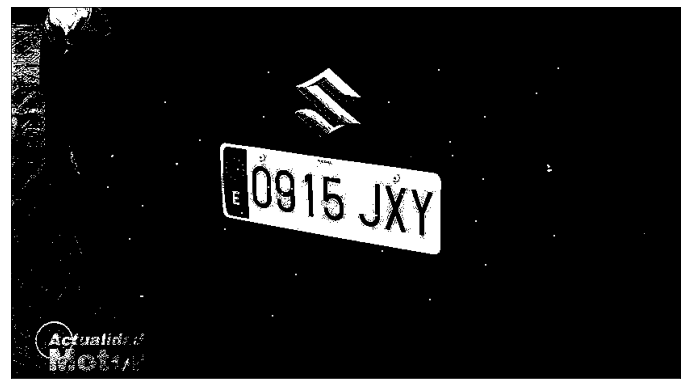

Imagen tratada


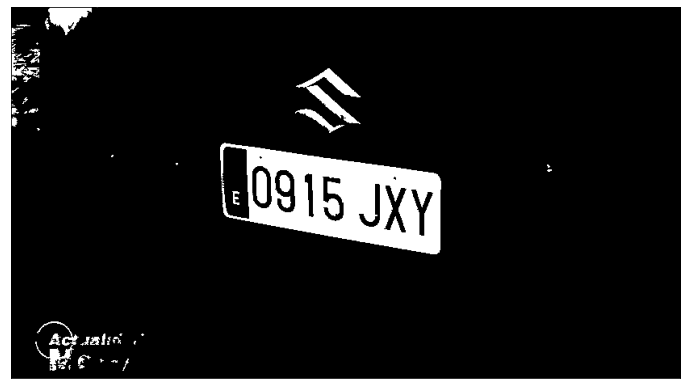

In [9]:
img_tratada = apertura_recon(img_tratada_cierre, se)


print('Imagen original')
imshow(img_umbralizada)

print('Imagen tratada')
imshow(img_tratada)

## IV. Detección de matrículas

A la imagen a la que se le ha hecho un doble cierre, aplicamos un desenfoque gausiano y una media para que los contornos de las imágenes sean lo más visibles posibles.

In [10]:
img_gauss = cv2.GaussianBlur(img_tratada,(17,17),1) 
img_gauss_median = cv2.medianBlur(img_gauss ,5)

Aplicaremos el filtro Canny, que buscará los bordes.

In [11]:
threshold1 = 0
threshold2 = 400

img_canny = cv2.Canny(img_gauss_median, threshold1, threshold2)

Utilizaremos la función findContours para encontrar todos los contornos cerrados de la imagen con filtro Canny. Gracias a la función minAreaRect, obtenemos los lados de un rectángulo que rodea los distintos contornos detectados. Utilizamos esos lados para aplicar una función de rectangularidad, que dividirá el área del contorno entre el área del rectángulo que lo cirscunscribe. Nos quedaremos solo con los contornos que tengan una rectangularidad cercana a 1. Por último, con la función drawCountours representamos los contornos encontrados en la imagen tratada previamente.

<img src="bici.png">

el area de la matrícula es 26144.5


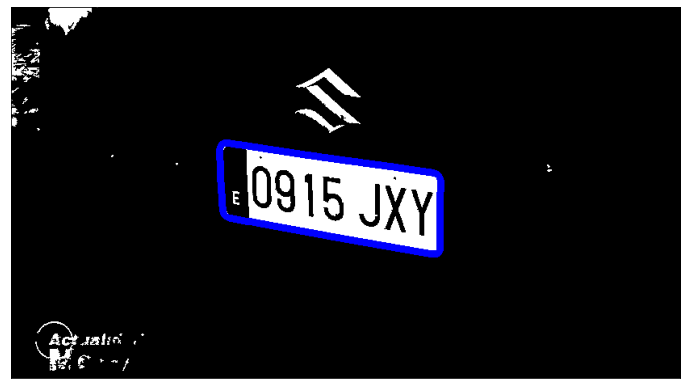

In [12]:
contour,hierarchy=cv2.findContours(img_canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

# encontramos el area más grande
max_area = -1
j=1
area=1
for i in range(len(contour)):
    area = cv2.contourArea(contour[i])
    (x, y), (width, height), angle=cv2.minAreaRect(contour[i])
    if area>max_area:
        cnt = contour[i]
        j=i
        max_area = area   
    try:
        rectangularity1 = area/(width*height)

    except:
        pass 

    if cv2.contourArea(contour[i]) >20000 and cv2.contourArea(contour[i])<5000000 and rectangularity1 >0.6:
        print('el area de la matrícula es', area)
        img_tratada_3d=cv2.cvtColor(img_tratada, cv2.COLOR_GRAY2BGR)
        img_tratada_contornos=cv2.drawContours(img_tratada_3d,contour[i],-1,(255,0,0),8,8)

img_tratada_contornos_rgb = cv2.cvtColor(img_tratada_contornos,cv2.COLOR_BGR2RGB)

imshow(img_tratada_contornos_rgb)

## V. Conclusiones



Hemos quedado muy contentos con el trabajo realizado y los resultados obtenidos, al implementar los algoritmos
de apertura y cierre con reconstrucción, basándonos en lo visto en clase, lo cual nos ha servido para comprender
mucho mejor estas operaciones. También hemos terminado realmente satisfechos con la detección de los contornos
de la matrícula, que como se puede ver en los resultados, se ajusta bastante bien a los bordes de la matrícula.